# MLP 205
* Operate on 16000 GenCode 34 seqs.
* 5-way cross validation. Save best model per CV.
* Report mean accuracy from final re-validation with best 5.
* Use Adam with a learn rate decay schdule.

In [11]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
DATAPATH=""
try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    NC_FILENAME = DATAPATH+NC_FILENAME
    PC_FILENAME = DATAPATH+PC_FILENAME
except:
    IN_COLAB = False
    DATAPATH="" 

EPOCHS=200
SPLITS=5
K=3
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
FILENAME='MLP205'
NEURONS=16

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

## Build model

In [13]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    opt = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    model.compile(loss=bc, optimizer=opt, metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model(maxlen):
    act="elu"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    dense1_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    #dense3_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation="sigmoid",dtype=dt)
    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    #mlp.add(dense3_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

## Load and partition sequences

In [14]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)



## Make K-mers

In [15]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1 -1:  # stop at minus one for spaced seed
            #kmer=seq[i:i+2]+seq[i+3:i+5]    # SPACED SEED 2/1/2 for K=4
            kmer=seq[i:i+K]  
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [16]:
def make_kmers(MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # From pandas dataframe to numpy to list to numpy
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [17]:
def make_frequencies(Xin):
    Xout=[]
    VOCABULARY_SIZE= 4**K + 1  # plus one for 'NNN'
    for seq in Xin:
        freqs =[0] * VOCABULARY_SIZE
        total = 0
        for kmerval in seq:
            freqs[kmerval] += 1
            total += 1
        for c in range(VOCABULARY_SIZE):
            freqs[c] = freqs[c]/total
        Xout.append(freqs)
    Xnum = np.asarray(Xout)
    return (Xnum)
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

## Cross validation

In [18]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=DATAPATH+FILENAME+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [19]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=load_fasta(NC_FILENAME,0)
pc_seq=load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
print ("Compile the model")
model=build_model(MAXLEN)
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(DATAPATH+FILENAME+'.model')
print ("Data prep")
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=make_kmers(MAXLEN,subset)
X_train=make_frequencies(X_train)

Load data from files.
Ready: train_set
Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________
None
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/MLP205.model/assets
Data prep
Data reshape


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4944 - accuracy: 0.7610 - val_loss: 0.3968 - val_accuracy: 0.8268
Epoch 2/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4310 - accuracy: 0.8052 - val_loss: 0.3903 - val_accuracy: 0.8349
Epoch 3/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4182 - accuracy: 0.8133 - val_loss: 0.4097 - val_accuracy: 0.8125
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4179 - accuracy: 0.8134 - val_loss: 0.4014 - val_accuracy: 0.8150
Epoch 5/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4125 - accuracy: 0.8139 - val_loss: 0.3849 - val_accuracy: 0.8374
Epoch 6/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4174 - accuracy: 0.8127 - val_loss: 0.3824 - val_accuracy: 0.8380
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4092 - accuracy: 0.816

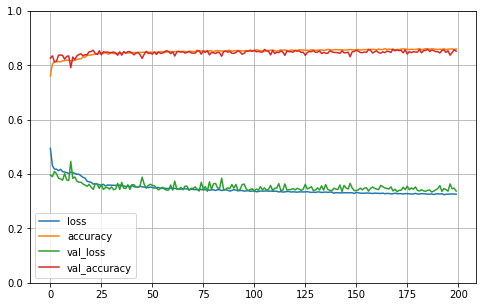

accuracy: 85.97%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 3ms/step - loss: 0.4872 - accuracy: 0.7688 - val_loss: 0.4419 - val_accuracy: 0.8038
Epoch 2/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4321 - accuracy: 0.8058 - val_loss: 0.4330 - val_accuracy: 0.8101
Epoch 3/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4129 - accuracy: 0.8161 - val_loss: 0.4642 - val_accuracy: 0.7796
Epoch 4/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4091 - accuracy: 0.8176 - val_loss: 0.4331 - val_accuracy: 0.8076
Epoch 5/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4057 - accuracy: 0.8192 - val_loss: 0.4275 - val_accuracy: 0.8156
Epoch 6/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4049 - accuracy: 0.8198 - val_loss: 0.4244 - val_accuracy: 0.8175
Epoch 7/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4015 - accuracy: 0.82

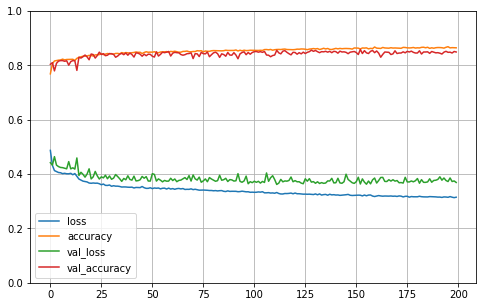

accuracy: 85.85%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4918 - accuracy: 0.7627 - val_loss: 0.4165 - val_accuracy: 0.8094
Epoch 2/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4303 - accuracy: 0.8091 - val_loss: 0.4252 - val_accuracy: 0.8094
Epoch 3/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4139 - accuracy: 0.8131 - val_loss: 0.4111 - val_accuracy: 0.8212
Epoch 4/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4124 - accuracy: 0.8168 - val_loss: 0.4045 - val_accuracy: 0.8318
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4095 - accuracy: 0.8175 - val_loss: 0.4048 - val_accuracy: 0.8293
Epoch 6/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4072 - accuracy: 0.8189 - val_loss: 0.4078 - val_accuracy: 0.8231
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4040 - accuracy: 0.82

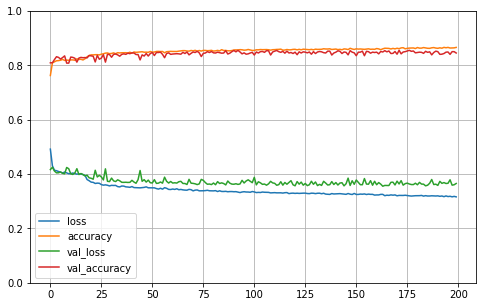

accuracy: 85.54%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4944 - accuracy: 0.7629 - val_loss: 0.5140 - val_accuracy: 0.7660
Epoch 2/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4286 - accuracy: 0.8082 - val_loss: 0.4115 - val_accuracy: 0.8138
Epoch 3/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4212 - accuracy: 0.8114 - val_loss: 0.4191 - val_accuracy: 0.8088
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4093 - accuracy: 0.8196 - val_loss: 0.4865 - val_accuracy: 0.7666
Epoch 5/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4070 - accuracy: 0.8179 - val_loss: 0.4055 - val_accuracy: 0.8144
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4048 - accuracy: 0.8191 - val_loss: 0.4310 - val_accuracy: 0.7989
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4046 - accuracy: 0.82

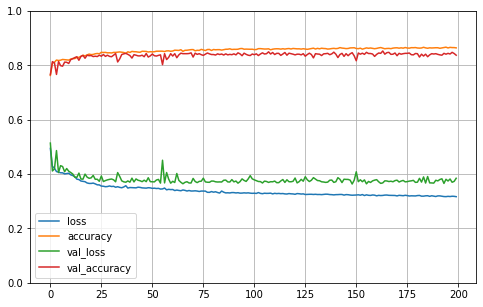

accuracy: 85.29%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5038 - accuracy: 0.7573 - val_loss: 0.4329 - val_accuracy: 0.8119
Epoch 2/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4270 - accuracy: 0.8093 - val_loss: 0.3979 - val_accuracy: 0.8237
Epoch 3/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4192 - accuracy: 0.8110 - val_loss: 0.3938 - val_accuracy: 0.8200
Epoch 4/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4141 - accuracy: 0.8158 - val_loss: 0.3856 - val_accuracy: 0.8206
Epoch 5/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4111 - accuracy: 0.8180 - val_loss: 0.3853 - val_accuracy: 0.8268
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4079 - accuracy: 0.8163 - val_loss: 0.3817 - val_accuracy: 0.8225
Epoch 7/200
453/453 [==============================] - 2s 3ms/step - loss: 0.4081 - accuracy: 0.81

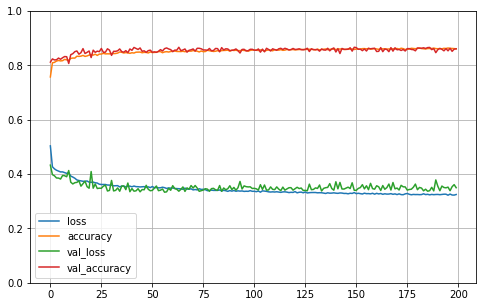

accuracy: 86.65%

5-way Cross Validation mean 85.86% (+/- 0.46%)
Done


In [20]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")